In [12]:
import pandas as pd # Pandas es una biblioteca de análisis y manipulación de datos.
import numpy as np # Numpy es una biblioteca para el cálculo numérico en Python.
import matplotlib.pyplot as plt # Matplotlib es una biblioteca para la creación de gráficos en Python.
from scipy.stats import norm # La distribución normal es una distribución de probabilidad continua que se utiliza ampliamente en estadística.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import pickle

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
cs_df = pd.read_csv(name, sep=",", encoding='UTF-8')

Saving DF_CS_ARREGLADO.csv to DF_CS_ARREGLADO.csv


count    666.000000
mean      79.792793
std       20.357017
min        6.000000
25%       68.000000
50%       86.000000
75%       94.000000
max      114.000000
Name: RoundKills, dtype: float64


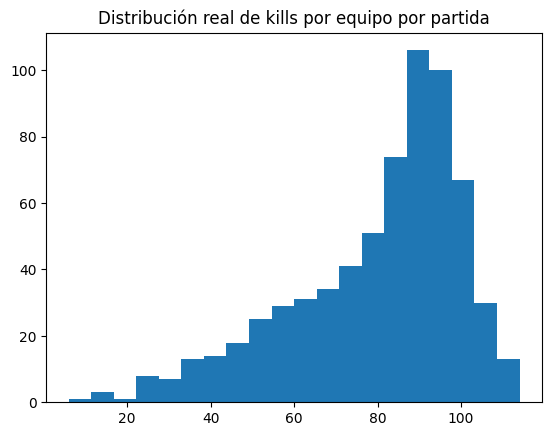

In [15]:
# Agrupar estadísticas por Match y equipo interno (0 o 1)
datos = cs_df.groupby(['MatchId', 'InternalTeamId']).agg({
    'RoundKills': 'sum',
    'TeamStartingEquipmentValue': 'mean',
    'PrimarySniperRifle': 'mean',
    'RLethalGrenadesThrown': 'sum',
    'RNonLethalGrenadesThrown': 'sum',
    'PrimaryHeavy': 'mean',
    'PrimarySMG': 'mean',
    'PrimaryPistol': 'mean'
}).reset_index()
print(datos['RoundKills'].describe())
plt.hist(datos['RoundKills'], bins=20)
plt.title('Distribución real de kills por equipo por partida')
plt.show()

In [16]:
# Crear columna binaria de si el equipo ganó el match
ganadores = cs_df[['MatchId', 'InternalTeamId', 'MatchWinner']].drop_duplicates()
ganadores['WonMatch'] = (ganadores['InternalTeamId'] == ganadores['MatchWinner']).astype(int)

# Unir con los datos agregados
datos = datos.merge(
    ganadores[['MatchId', 'InternalTeamId', 'WonMatch']],
    on=['MatchId', 'InternalTeamId'],
    how='left'
)


In [17]:
# Definir las features y la variable objetivo
features = [
    'RoundKills',
    'TeamStartingEquipmentValue',
    'PrimarySniperRifle',
    'RLethalGrenadesThrown',
    'RNonLethalGrenadesThrown',
    'PrimaryHeavy',
    'PrimarySMG',
    'PrimaryPistol'
]

X = datos[features]
y = datos['WonMatch']


# Random Forest

# Modelamiento

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       100
           1       0.79      0.65      0.71        34

    accuracy                           0.87       134
   macro avg       0.84      0.79      0.81       134
weighted avg       0.86      0.87      0.86       134



Se aprecia que siendo 0 para las partidas perdidas y 1 para las partidas ganadas. Que el modelo predice con un 87% de exactitud si un equipo ganara la partida.

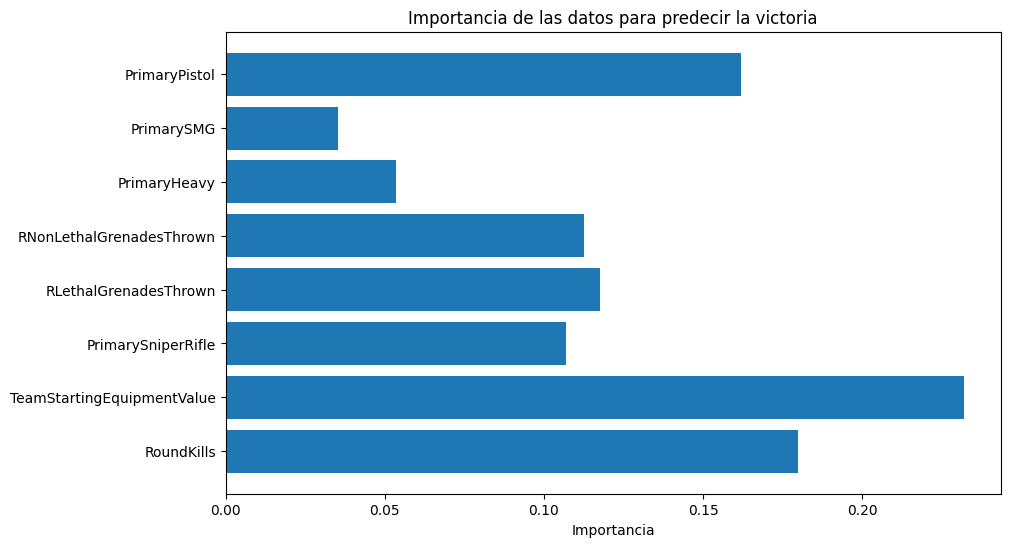

In [25]:
importances = model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feat_names, importances)
plt.xlabel("Importancia")
plt.title("Importancia de las datos para predecir la victoria")
plt.show()